<h4><strong>Data Load</strong></h4>

In [4]:
import pandas as pd

data = pd.read_csv("../data/hungarian_heart_diseases.csv")
X = data.drop(columns=["outcome"])
y = data["outcome"]

<h4><strong>1. Using a stratified 80-20 training-testing split with a fixed seed (random_state=1), assess in a single plot both the training and testing accuracies of a decision tree with minimum sample leaf in {1, 3, 5, 10, 25, 50, 100} and the remaining parameters as default.</strong></h4>

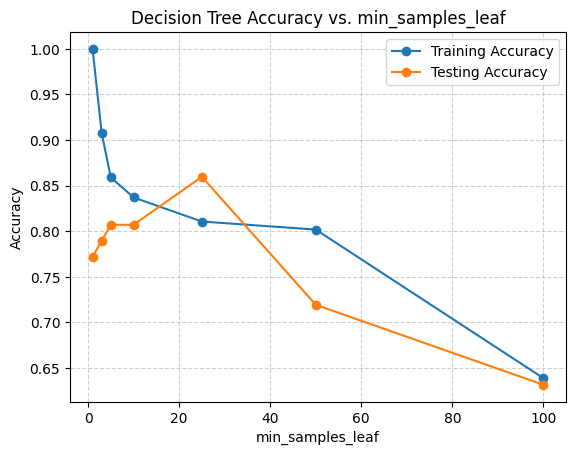

In [5]:
from sklearn import model_selection, tree, metrics
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, random_state=1, stratify=y
)

clf = tree.DecisionTreeClassifier(random_state=1)

min_samples_leaf_values = [1, 3, 5, 10, 25, 50, 100]

train_accuracies, test_accuracies = [], []

for m in min_samples_leaf_values:
    clf.set_params(min_samples_leaf=m)
    clf.fit(X_train, y_train)

    train_acc = metrics.accuracy_score(y_train, clf.predict(X_train))
    test_acc = metrics.accuracy_score(y_test, clf.predict(X_test))

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plot dos resultados
# plt.figure(figsize=(8, 5))
plt.plot(
    min_samples_leaf_values, train_accuracies, marker="o", label="Training Accuracy"
)
plt.plot(min_samples_leaf_values, test_accuracies, marker="o", label="Testing Accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy vs. min_samples_leaf")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

<h4><strong>2. Critically analyze these results, including the generalization capacity across settings.</strong></h4>

<p>From the plot we can see that when min_samples_leaf = 1 the tree gets almost perfect accuracy on the training set, but the testing accuracy is lower. This means the model is overfitting, because it memorizes the training data and does not generalize so well.</p>

<p>When we increase min_samples_leaf, the training accuracy goes down since the tree is more limited, but the testing accuracy becomes a bit better and more stable. This shows that the model is generalizing better, because it is not just fitting the noise in the training set.</p>

<p>For very large values like 50 or 100, both training and testing accuracies drop. Here the tree is too simple and cannot capture enough information, which is underfitting.</p>

<p>In general, the best value is the one with the highest testing accuracy (where min_samples_leaf = 10, 25), because this shows the model can generalize. Still, looking at the balance between training and testing also helps to see if the model is overfitting or underfitting.</p>


<h4><strong>3. A healthcare provider requested the development of a predictive model achieving at least 80% validation accuracy and 78.5% test accuracy. The dataset must be split into training, validation, and testing sets (60–20–20), using a stratified split. The goal is to identify a model that satisfies the required accuracy within the following hyperparameter ranges: max_depth ∈ [2,4] and min_samples_split ∈ [2,100]. All other hyperparameters should be kept at their default values. Use random_state = 1 to split the data and to create the model.
<br><br>i. Plot the decision tree.</strong></h4>

Best model: DecisionTreeClassifier(max_depth=4, min_samples_split=18, random_state=1)
Validation accuracy: 0.8070175438596491
Test accuracy: 0.7894736842105263


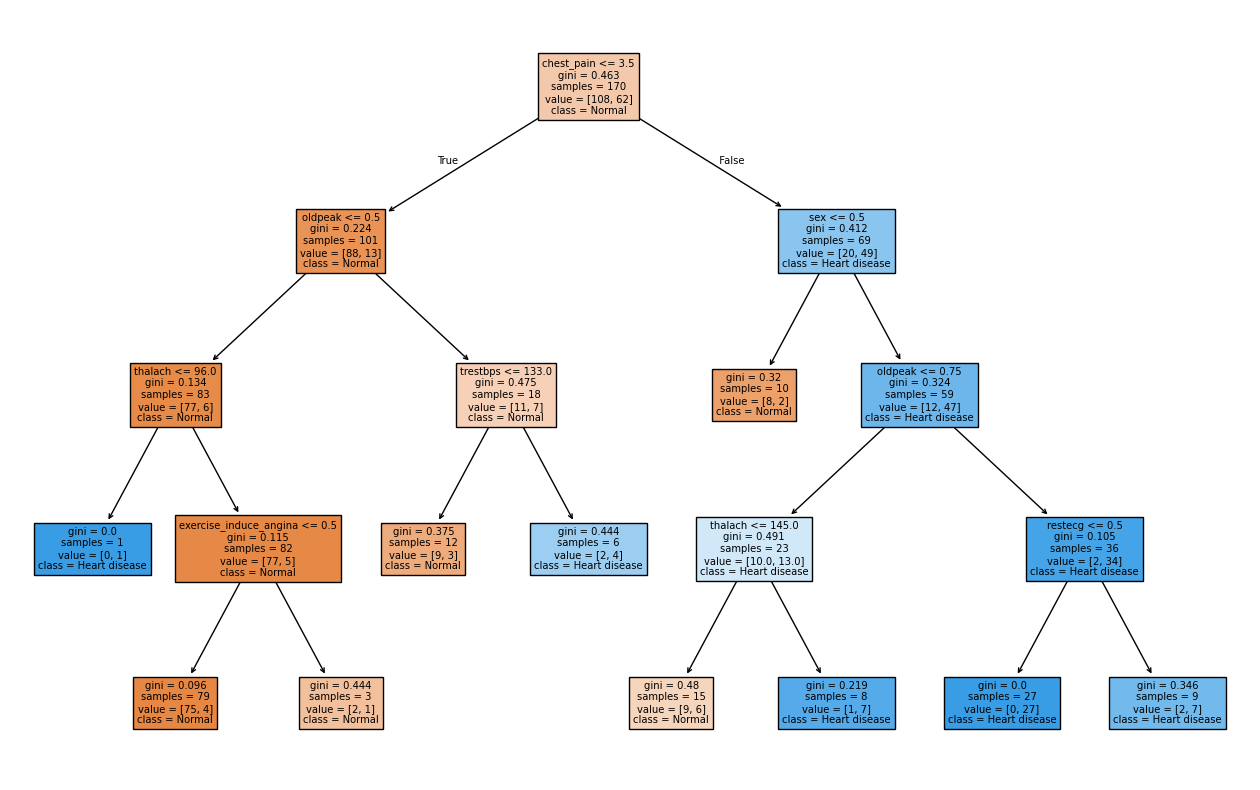

In [6]:
X_train, X_temp, y_train, y_temp = model_selection.train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=1
)

X_val, X_test, y_val, y_test = model_selection.train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=1
)

best_model = None
best_val_acc = 0
best_test_acc = 0

for depth in [2, 3, 4]:
    for split in range(2, 101):
        clf = tree.DecisionTreeClassifier(
            max_depth=depth, min_samples_split=split, random_state=1
        )
        clf.fit(X_train, y_train)

        val_acc = metrics.accuracy_score(y_val, clf.predict(X_val))
        test_acc = metrics.accuracy_score(y_test, clf.predict(X_test))

        if val_acc >= 0.80 and test_acc >= 0.785:
            best_val_acc = val_acc
            best_test_acc = test_acc
            best_model = clf

print("Best model:", best_model)
print("Validation accuracy:", best_val_acc)
print("Test accuracy:", best_test_acc)

# Plot the decision tree
plt.figure(figsize=(16, 10))
tree.plot_tree(
    best_model,
    feature_names=X.columns,
    class_names=["Normal", "Heart disease"],
    filled=True,
)
plt.show()


<h4><strong>ii. Explain what characterizes heart diseases by identifying the conditional associations together with their posterior probabilities.</strong></h4>


1. chest_pain ≤ 3.5 AND oldpeak ≤ 0.5 AND thalach ≤ 96 → P(Heart disease) = 1/1 =100%.<br>
2. chest_pain ≤ 3.5 AND oldpeak > 0.5 AND trestbps > 133 → P(Heart disease) = 4/6 ≈ 66.7%. <br>
3. chest_pain > 3.5 AND sex > 0.5 AND oldpeak ≤ 0.75 AND thalach > 145 → P(Heart disease) = 7/8 ≈ 87.5%.<br>
4. chest_pain > 3.5 AND sex > 0.5 AND oldpeak > 0.75 AND restecg ≤ 0.5 → P(Heart disease) = 27/27 = 100%.<br>
5. chest_pain > 3.5 AND sex > 0.5 AND oldpeak > 0.75 AND restecg > 0.5 → P(Heart disease) = 7/9 ≈ 78%. <br>


The decision tree reveals several conditional associations that characterize patients with heart disease. For patients with mild chest pain (chest_pain ≤ 3.5), the outcome depends further on oldpeak. If oldpeak ≤ 0.5, then a very low maximum heart rate (thalach ≤ 96) indicates heart disease with 100% probability. If instead oldpeak > 0.5, then high resting blood pressure (trestbps > 133) is associated with heart disease with 66.7% probability. 

When chest pain is more severe (chest_pain > 3.5), the model identifies particularly strong signals among men (sex > 0.5). In this branch, a combination of low stress tolerance (thalach > 145) and low ST depression (oldpeak ≤ 0.75) leads to 87.5% probability of heart disease. Furthermore, if oldpeak > 0.75, both abnormal and normal restecg values still point strongly to heart disease, with posterior probabilities of 100% and 77.8%, respectively. 

These results show that chest pain type, exercise tolerance, resting blood pressure, and stress test abnormalities are the most important factors in identifying heart disease, with posterior probabilities ranging from moderate (~66.7%) to very high (100% in some leaves).

